In [1]:
import torchvision.models as models
import torch.nn as nn
import torch

In [2]:
resnet50 = models.resnet50(pretrained=True)

In [3]:
def get_resnet50_backbone(resnet50: nn.Module):
    features = list(resnet50.children())[:-2]
    for feature in features[:-2]:
        for parameter in feature.parameters():
            parameter.requires_grad = False
    return nn.Sequential(*features)


In [4]:
class Resnet50Yolo(nn.Module):
    def __init__(self, resnet50):
        super(Resnet50Yolo, self).__init__()
        self.resnet50_backbone = get_resnet50_backbone(resnet50=resnet50)
        self.last_conv = nn.Conv2d(2048, 1024, (3, 3), padding=1, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7*7*1024, 4096)
        self.fc2 = nn.Linear(4096, 7*7*30)

    def forward(self, x: torch.Tensor):
        x = self.resnet50_backbone(x)
        x = self.last_conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x


In [5]:
class YoloLoss(nn.Module):
    def __init__(self, l_coord=5, l_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.l_coord = l_coord
        self.l_noobj = l_noobj

    @ staticmethod
    def compute_iou(box1, box2):
        pass

    def forward(self, pred: torch.Tensor, truth: torch.Tensor):
        # 7*7*30
        pred = pred.reshape(-1, 30)
        truth = truth.reshape(-1, 30)
        # 有物体存在和没有物体存在的index
        coo_mask = (truth[..., 4] > 0).unsqueeze(-1).expand_as(truth)
        noo_mask = (truth[..., 4] == 0).unsqueeze(-1).expand_as(truth)
        # 有物体存在和没有物体存在的具体数据
        coo_pred = pred[coo_mask].reshape(-1, 30)
        box_pred = coo_pred[..., :10].reshape(-1, 5)
        class_pred = coo_pred[..., 10:]

        coo_truth = truth[coo_mask].reshape(-1, 30)
        box_truth = coo_truth[..., :10].reshape(-1, 5)
        class_truth = coo_truth[..., 10:]

        # 使用最大的iou输出作为训练
        box_truth = box_truth[..., :10]
        # 每个grid cell会有两个B的输出，在训练时选择那个IOU最大的用于训练
        box_pred_response_mask = torch.BoolTensor(box_truth.size()[0]).zero_()
        box_truth_response_mask = torch.BoolTensor(box_truth.size()[0]).zero_()
        for i in range(0, box_truth.size()[0], 2):
            box_truth_response_mask[i] = True
            if self.compute_iou(box_pred[i][:4], box_truth[i][:4]) > \
                    self.compute_iou(box_pred[i+1][:4], box_truth[i][:4]):
                box_pred_response_mask[i] = True
            else:
                box_pred_response_mask[i+1] = True

        # 计算存在物体时候的定位损失
        coo_loc_loss = torch.nn.functional.cross_entropy(
            box_pred[box_pred_response_mask][..., :2],
            box_truth[box_truth_response_mask][..., :2])
        # 计算存在物体时候的大小损失
        coo_wh_loss = torch.nn.functional.cross_entropy(
            box_pred[box_pred_response_mask][..., 2:4],
            box_truth[box_truth_response_mask][..., 2:4])
        # 计算存在物体时的置信度损失
        coo_c_loss = torch.nn.functional.cross_entropy(
            box_pred[box_pred_response_mask][..., 4],
            box_truth[box_truth_response_mask][..., 4])
        coo_c_loss = 0
        # 计算不存在物体时的置信度损失
        noo_pred = pred[noo_mask].reshape(-1, 30)
        noo_truth = truth[noo_mask].reshape(-1, 30)
        noo_c_loss = torch.nn.functional.cross_entropy(
            noo_pred[..., [4, 9]], noo_truth[..., [4, 9]])
        # 计算存在物体时的类别损失
        coo_class_loss = torch.nn.functional.cross_entropy(
            class_pred, class_truth)

        loss = self.l_coord * coo_loc_loss \
            + self.l_coord * coo_wh_loss \
            + coo_c_loss \
            + self.l_noobj * noo_c_loss \
            + coo_class_loss
        return loss


In [9]:
resnet50_yolo = Resnet50Yolo(resnet50)

# 使用voc数据集进行训练

In [63]:
import torchvision.datasets as datasets
import numpy as np
from torch.utils.data import Dataset

In [ ]:
class RandomVoc(Dataset):
    pass

In [87]:
target_tensor = torch.Tensor(1470)
target_tensor = target_tensor.reshape(-1,30)
target_tensor.size()

torch.Size([49, 30])

In [102]:
def class_index(class_name: str):
    if not hasattr(class_index, 'classes'):
        with open('./classes.txt', 'r') as f:
            setattr(class_index, 'classes', [_.strip() for _ in f.readlines()])
    return class_index.classes.index(class_name)


In [177]:
def target_transform(target):
    # return target
    objects = target['annotation']['object']
    target_tensor = torch.Tensor(7, 7, 30).zero_()
    for obj in objects:
        class_i = class_index(obj['name'])
        bndbox = obj['bndbox']
        x = (int(bndbox['xmax']) + int(bndbox['xmin'])) / 2
        y = (int(bndbox['ymax']) + int(bndbox['ymin'])) / 2
        w = (int(bndbox['xmax']) - int(bndbox['xmin']))
        h = (int(bndbox['ymax']) - int(bndbox['ymin']))

        x_i = int(x // 64)
        y_i = int(y // 64)

        x = x % 64 / 64
        y = y % 64 / 64
        w = w / 448
        h = h / 448

        target_tensor[y_i, x_i][0] = x
        target_tensor[y_i, x_i][1] = y
        target_tensor[y_i, x_i][2] = w
        target_tensor[y_i, x_i][3] = h
        target_tensor[y_i, x_i][4] = 1
        target_tensor[y_i, x_i][10+class_i] = 1

    return target_tensor


In [178]:
voc_trainset = datasets.VOCDetection(
    '../../datasets/voc/2012/',
    year='2012',
    image_set='train',
    download=False,
    transform=torchvision.transforms.ToTensor(),
    target_transform=target_transform)

In [179]:
import torchvision

In [183]:
img, target = next(iter(voc_trainset))


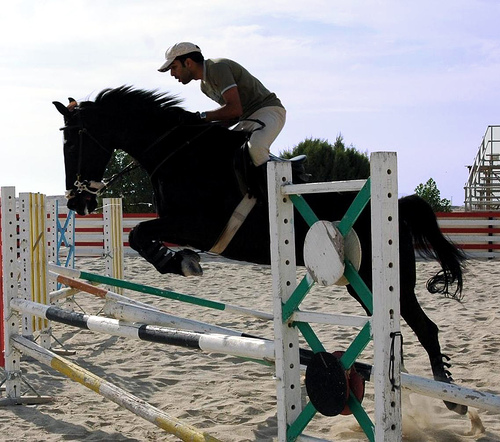

In [184]:
torchvision.transforms.ToPILImage()(img)